## Importing libraries and PostgreSQL configuration

In [1]:
import pandas as pd
from sqlalchemy import create_engine, text
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

with open('C:/Users/Usuario/Workshop_ETL/Workshop_ETL/config.json', 'r', encoding='utf-8') as f:
    config = json.load(f)

user = config['POSTGRES_USER']
password = config['POSTGRES_PASSWORD']
host = config['POSTGRES_HOST']
port = config['POSTGRES_PORT']
database = config['POSTGRES_DB']

In [2]:
engine = create_engine(f"postgresql://{user}:{password}@{host}:{port}/{database}")

query = "SELECT * FROM workshop_table;"

df = pd.read_sql(query, engine)
df.head()

,First Name,Last Name,Email,Application Date,Country,YOE,Seniority,Technology,Code Challenge Score,Technical Interview Score,Hiring
0,Bernadette,Langworth,leonard91@yahoo.com,2021-02-26,Norway,2,Intern,Data Engineer,3,3,Rejected
1,Camryn,Reynolds,zelda56@hotmail.com,2021-09-09,Panama,10,Intern,Data Engineer,2,10,Rejected
2,Larue,Spinka,okey_schultz41@gmail.com,2020-04-14,Belarus,4,Mid-Level,Client Success,10,9,Hired
3,Arch,Spinka,elvera_kulas@yahoo.com,2020-10-01,Eritrea,25,Trainee,QA Manual,7,1,Rejected
4,Larue,Altenwerth,minnie.gislason@gmail.com,2020-05-20,Myanmar,13,Mid-Level,Social Media Community Management,9,7,Hired


In [3]:
df.describe()

,YOE,Code Challenge Score,Technical Interview Score
count,50000.000000,50000.000000,50000.000000
mean,15.286980,4.996400,5.003880
std,8.830652,3.166896,3.165082
min,0.000000,0.000000,0.000000
25%,8.000000,2.000000,2.000000
50%,15.000000,5.000000,5.000000
75%,23.000000,8.000000,8.000000
max,30.000000,10.000000,10.000000


#### Thanks to the method describe, we can see that in terms of Year of Experience (YOE) the average is 15 years, but the scores in both exams had an average of 5. This is alarming because it shows that in general the candidates were not prepared, and in the end this will be reflected in a low level of hired candidates this is supported by the standard deviation.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   First Name                 50000 non-null  object
 1   Last Name                  50000 non-null  object
 2   Email                      50000 non-null  object
 3   Application Date           50000 non-null  object
 4   Country                    50000 non-null  object
 5   YOE                        50000 non-null  int64 
 6   Seniority                  50000 non-null  object
 7   Technology                 50000 non-null  object
 8   Code Challenge Score       50000 non-null  int64 
 9   Technical Interview Score  50000 non-null  int64 
 10  Hiring                     50000 non-null  object
dtypes: int64(3), object(8)
memory usage: 4.2+ MB


#### According to the information provided, there are no null values, which is good, that means we won't have a problem with the visualization. However, all columns (except YOE, Code Challenge Score, Technical Interview Score, Application Date) have "Object" as data type. This could be a problem for the analysis, because the result can change, so we need to convert them to the correct one.

In [8]:
df['First Name'] = df['First Name'].astype("string")
df['Last Name'] = df['Last Name'].astype("string")
df['Email'] = df['Email'].astype("string")
df['Application Date'] = pd.to_datetime(df['Application Date'], format='%Y/%m/%d')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   First Name                 50000 non-null  string        
 1   Last Name                  50000 non-null  string        
 2   Email                      50000 non-null  string        
 3   Application Date           50000 non-null  datetime64[ns]
 4   Country                    50000 non-null  object        
 5   YOE                        50000 non-null  int64         
 6   Seniority                  50000 non-null  object        
 7   Technology                 50000 non-null  object        
 8   Code Challenge Score       50000 non-null  int64         
 9   Technical Interview Score  50000 non-null  int64         
 10  Hiring                     50000 non-null  object        
dtypes: datetime64[ns](1), int64(3), object(4), string(3)
memory usage: 

#### Now, the columns have the right data type and the result will be more effective

## Calculate Hiring

#### The "Hired" column is created, which contains the final result whether the candidate was hired or rejected, and then the table in the database is updated with the new information.

In [9]:
def hiring(code_score, technical_score):
    return np.where((code_score >= 7) & (technical_score >= 7), 'Hired', 'Rejected')

df['Hiring'] = hiring(df['Code Challenge Score'], df['Technical Interview Score'])
df.head()

,First Name,Last Name,Email,Application Date,Country,YOE,Seniority,Technology,Code Challenge Score,Technical Interview Score,Hiring
0,Bernadette,Langworth,leonard91@yahoo.com,2021-02-26,Norway,2,Intern,Data Engineer,3,3,Rejected
1,Camryn,Reynolds,zelda56@hotmail.com,2021-09-09,Panama,10,Intern,Data Engineer,2,10,Rejected
2,Larue,Spinka,okey_schultz41@gmail.com,2020-04-14,Belarus,4,Mid-Level,Client Success,10,9,Hired
3,Arch,Spinka,elvera_kulas@yahoo.com,2020-10-01,Eritrea,25,Trainee,QA Manual,7,1,Rejected
4,Larue,Altenwerth,minnie.gislason@gmail.com,2020-05-20,Myanmar,13,Mid-Level,Social Media Community Management,9,7,Hired


In [10]:
postgres_url = f"postgresql://{user}:{password}@{host}:{port}/{database}"
engine = create_engine(postgres_url)
table_name = 'workshop_table'

df.to_sql(table_name, engine, if_exists='replace', index=False)

print("The data has been inserted correctly into the table, overwriting existing columns if necessary.")

The data has been inserted correctly into the table, overwriting existing columns if necessary.


## Graphics

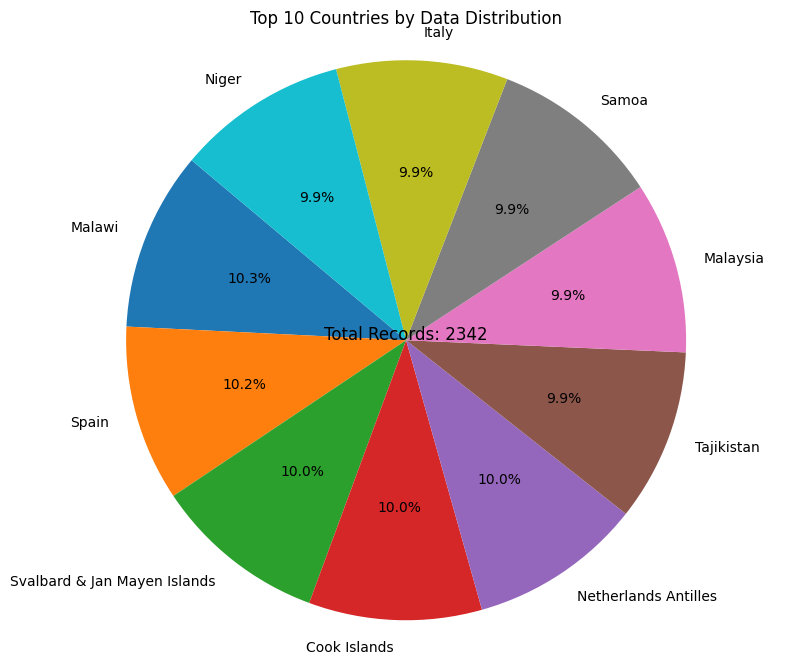

In [11]:
country_distribution = df['Country'].value_counts().head(10)

plt.figure(figsize=(10, 8))
plt.pie(country_distribution, labels=country_distribution.index, autopct='%1.1f%%', startangle=140)
plt.title('Top 10 Countries by Data Distribution')
plt.axis('equal')
plt.text(0, 0, f'Total Records: {country_distribution.sum()}', color='black', fontsize=12, ha='center')
plt.show()